# Benchmarking the Permanent

This tutorial shows how to use the permanent function using The Walrus, which calculates the permanent using Ryser's algorithm

### The Permanent
The permanent of an $n$-by-$n$ matrix A = $a_{i,j}$ is defined as

$\text{perm}(A)=\sum_{\sigma\in S_n}\prod_{i=1}^n a_{i,\sigma(i)}.$

The sum here extends over all elements $\sigma$ of the symmetric group $S_n$; i.e. over all permutations of the numbers $1, 2, \ldots, n$. ([see Wikipedia](https://en.wikipedia.org/wiki/Permanent)).

The function `thewalrus.perm` implements [Ryser's algorithm](https://en.wikipedia.org/wiki/Computing_the_permanent#Ryser_formula) to calculate the permanent of an arbitrary matrix using [Gray code](https://en.wikipedia.org/wiki/Gray_code) ordering.

## Using the library

Once installed or compiled, one imports the library in the usual way:

In [1]:
from thewalrus import perm

To use it  we need to pass square numpy arrays thus we also import NumPy:

In [2]:
import numpy as np
import time

The library provides functions to compute permanents of real and complex matrices. The functions take as arguments the matrix; the number of threads to be used to do the computation are determined using OpenMP.

In [5]:
size = 20
matrix = np.ones([size,size])
perm(matrix)

2.4329026325996175e+18

In [6]:
size = 20
matrix = np.ones([size,size], dtype=np.complex128)
perm(matrix)

2.4329026325996175e+18

Not surprisingly, the permanent of a matrix containing only ones equals the factorial of the dimension of the matrix, in our case $20!$.

In [8]:
from math import factorial
factorial(20)

2432902008176640000

### Benchmarking the performance of the code

For sizes $n=1,28$ we will generate random unitary matrices and measure the (average) amount of time it takes to calculate their permanent. The number of samples for each will be geometrically distirbuted with a 1000 samples for size $n=1$ and 10 samples for $n=28$. The unitaries will be random Haar distributed.

In [9]:
a0 = 1000.
anm1 = 10.
n = 28
r = (anm1/a0)**(1./(n-1))
nreps = [(int)(a0*(r**((i)))) for i in range(n)]

In [10]:
nreps

[1000,
 843,
 710,
 599,
 505,
 426,
 359,
 303,
 255,
 215,
 181,
 153,
 129,
 108,
 91,
 77,
 65,
 55,
 46,
 39,
 33,
 27,
 23,
 19,
 16,
 14,
 11,
 10]

The following function generates random Haar unitaries of dimensions $n$

In [11]:
from scipy import diagonal, randn
from scipy.linalg import qr
def haar_measure(n):
    '''A Random matrix distributed with Haar measure
    See https://arxiv.org/abs/math-ph/0609050
    How to generate random matrices from the classical compact groups
    by Francesco Mezzadri '''
    z = (randn(n,n) + 1j*randn(n,n))/np.sqrt(2.0)
    q,r = qr(z)
    d = diagonal(r)
    ph = d/np.abs(d)
    q = np.multiply(q,ph,q)
    return q

Now let's bench mark the scaling of the calculation with the matrix size:

In [13]:
times = np.empty(n)
for ind, reps in enumerate(nreps):
    #print(ind+1,reps)
    start = time.time()
    for i in range(reps):
        size = ind+1
        nth = 1
        matrix = haar_measure(size)
        res = perm(matrix)
    end = time.time()
    times[ind] = (end - start)/reps
    print(ind+1, times[ind])

1 0.000128142356873
2 0.000113451608135
3 0.000126649964024
4 0.000147170733928
5 0.00015127068699
6 0.000151018021812
7 0.000160156850363
8 0.000172159459331
9 0.000182725868973
10 0.000207343212394
11 0.000255089438423
12 0.000354059381423
13 0.00056652690089
14 0.00098239492487
15 0.00186866980333
16 0.0038534418329
17 0.00759140161368
18 0.0151191147891
19 0.0309824477071
20 0.0688854792179
21 0.149397438223
22 0.309583354879
23 0.638324841209
24 1.36122394863
25 2.87367682159
26 5.89191659859
27 12.0298262509
28 25.0051065683


We can now plot the (average) time it takes to calculate the permanent vs. the size of the matrix:

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

Text(0,0.5,'Time in seconds for 4 threads')

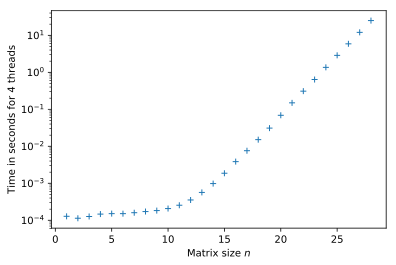

In [15]:
plt.semilogy(np.arange(1,n+1),times,"+")
plt.xlabel(r"Matrix size $n$")
plt.ylabel(r"Time in seconds for 4 threads")

We can also fit to the theoretical scaling of $ c n 2^n$ and use it to extrapolate for larger sizes:

In [16]:
def fit(n,c):
    return c*n*2**n

In [17]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit, np.arange(1,n+1)[15:-1],times[15:-1])

The scaling prefactor is 

In [18]:
popt[0]

3.3347324775062932e-09

And we can use it to extrapolate the time it takes to calculate permanents of bigger dimensions

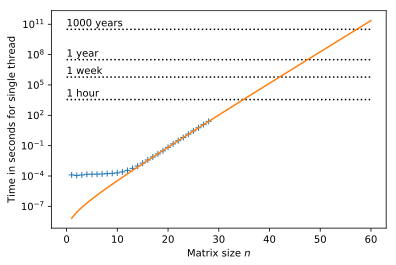

In [19]:
flags = [3600,3600*24*7, 3600*24*365, 3600*24*365*1000]
labels = ["1 hour", "1 week", "1 year", "1000 years"]
plt.semilogy(np.arange(1,n+1), times, "+", np.arange(1,61), fit(np.arange(1,61),popt[0]))
plt.xlabel(r"Matrix size $n$")
plt.ylabel(r"Time in seconds for single thread")
plt.hlines(flags,0,60,label="1 hr",linestyles=u'dotted')
for i in range(len(flags)):
    plt.text(0,2*flags[i], labels[i])

The specs of the computer on which this benchmark was performed are:

In [20]:
!cat /proc/cpuinfo|head -19 

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 94
model name	: Intel(R) Core(TM) i5-6400T CPU @ 2.20GHz
stepping	: 3
microcode	: 0xc2
cpu MHz		: 845.143
cache size	: 6144 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 22
wp		: yes


If you use this library in your research please cite it:

In [21]:
!cat hafnian.bib

@ARTICLE{2018arXiv180512498B,
   author = {{Bj{\"o}rklund}, A. and {Gupt}, B. and {Quesada}, N.},
   title = "{A faster hafnian formula for complex matrices and its benchmarking on the Titan supercomputer}",
   journal = {ArXiv e-prints},
   archivePrefix = "arXiv",
   eprint = {1805.12498},
   primaryClass = "cs.DS",
   keywords = {Computer Science - Data Structures and Algorithms},
   year = 2018
}

